In [1]:
cd ../

/Users/tombutler/Documents/ai-hackathon


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

import seaborn as sns
import matplotlib.pyplot as plt

from data.processed.pre_process_titanic import pre_process_df

### Parameters

In [4]:
TRAIN_DATA_PATH = "data/raw/train.csv"

NUM_COLUMNS = ["Fare", "Age"]

In [5]:
# CAT_COLUMNS = [f"embarked_{c}" for c in enc.categories_[0]]
# COLUMNS = data.columns.tolist() + CAT_COLUMNS

### 1. Load in the real data and prepare it

In [6]:
# Load the Titanic dataset
data = pre_process_df(TRAIN_DATA_PATH)

### 2. Visualise the data

See what the seaborn pair-plot can show for insight into the numeric feature distributions.

In [6]:
data = data[NUM_COLUMNS]

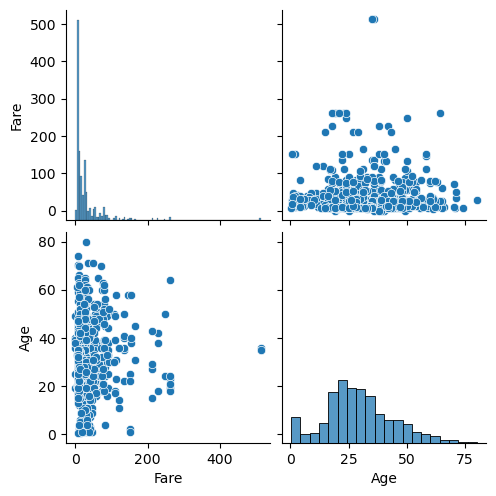

In [14]:
sns.pairplot(data[NUM_COLUMNS])
plt.show()

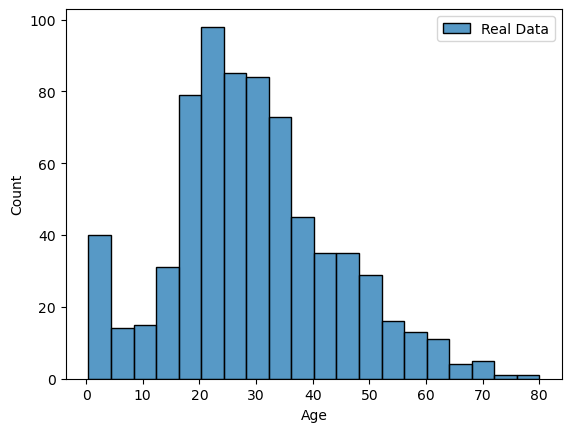

In [11]:
sns.histplot(data["Age"], label="Real Data")
plt.legend()
plt.show()

In [7]:
numerical_feature_means = np.mean(data, axis=0)
numerical_feature_stddev = np.std(data, axis=0)

In [8]:
# Impute missing values
imputer = SimpleImputer(strategy="median")
data = imputer.fit_transform(data)

In [9]:
# Normalize the data
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

### 3. Define the model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

### Discriminator

#### Sigmoid Output
The discriminator needs to output a value of 0-1 indicating whether an image is *real* or *fake*.

> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** and binary cross entropy loss in one function. 


So the final layer will not have an activation function applied to it.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers - have 3 fully-connected layers to start
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        
        x = F.leaky_relu(self.fc1(x), 0.2) # input, negative slope=0.2
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # final layer
        out = self.fc4(x)

        return out


### Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

We want the outputs to be comparable to the *real* inputs from the tabular dataset, so the real input needs to be scaled to -1 and 1 when we train the discriminator.

In [16]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # final layer should have tanh applied
        out = F.tanh(self.fc4(x))
        
        return out

### Model hyperparameters

In [17]:
# Discriminator hyperparams

# Size of input to discriminator
# this will be the number of features from the real data
input_size = 2
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 2
# Size of *first* hidden layer in the generator
g_hidden_size = 32

### Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [18]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z, c):
        x = torch.cat((z, c), dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [ ]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [ ]:
# Define the GAN model
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        
    def forward(self, z, c):
        x = self.generator(z, c)
        return self.discriminator(x)



In [ ]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    criterion = nn.BCEWithLogitsLoss()    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()    
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
def generator_loss(fake_output):
    return bce_loss(fake_output, torch.ones_like(fake_output))

def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(real_output, torch.ones_like(real_output))
    fake_loss = bce_loss(fake_output, torch.zeros_like(fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Define the optimizer
lr = 1e-4
beta1 = 0

In [ ]:
# Define the loss functions
bce_loss = nn.BCELoss()

# Set the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the hyperparameters
batch_size = 128
latent_dim = 128
num_categories = len(NUM_COLUMNS)
num_epochs = 100
num_batches = int(data.shape[0] / batch_size)

# Initialize the models
generator = Generator(input_dim=latent_dim, output_dim=data.shape[1])
discriminator = Discriminator(input_dim=data.shape[1])
gan = GAN(generator, discriminator)

# Move the models to the device
generator.to(device)
discriminator.to(device)
gan.to(device)

# Define the optimizer
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Define the data loader
data_tensor = torch.tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Train the models
for epoch in range(num_epochs):
    for batch_idx, (real_data,) in enumerate(loader):
        # Train the discriminator on real data
        real_data = real_data.to(device)
        real_labels = torch.ones(real_data.shape[0], 1).to(device)
        fake_labels = torch.zeros(real_data.shape[0], 1).to(device)
        z = torch.randn(real_data.shape[0], latent_dim).to(device)
        c = torch.randint(0, 2, (real_data.shape[0], num_categories)).float().to(device)
        fake_data = generator(z, c).detach()
        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data)
        d_loss = discriminator_loss(real_output, fake_output)
        discriminator.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train the generator to fool the discriminator
        z = torch.randn(real_data.shape[0], latent_dim).to(device)
        c = torch.randint(0, 2, (real_data.shape[0], num_categories)).float().to(device)
        fake_data = generator(z, c)
        fake_output = discriminator(fake_data)
        g_loss = generator_loss(fake_output)
        generator.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print the loss
        if (batch_idx+1) % 10 == 0:
            print('Epoch [{}/{}], Batch [{}/{}], Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'
                  .format(epoch+1, num_epochs, batch_idx+1, num_batches, d_loss.item(), g_loss.item()))

In [ ]:
# Generate 10,000 records after every epoch
with torch.no_grad():
    z = torch.randn(10000, latent_dim).to(device)
    c = torch.randint(0, 2, (10000, num_categories)).float().to(device)
    fake_data = generator(z, c)
    fake_data = fake_data.cpu().numpy()

### 4. Discriminator and Generator losses

Now we need to calculate the losses.


### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [19]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size)
    
    criterion = nn.BCEWithLogitsLoss()    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()    
    loss = criterion(D_out.squeeze(), labels)
    return loss

### Optimisers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [20]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

### 5. Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training Titanic passengers        
2. Generate fake images
3. Compute the discriminator loss on fake, generated Titanic passengers     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake im Titanic passengers ges, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [34]:
# prepare data loader
train_loader = torch.utils.data.DataLoader(
    data[NUM_COLUMNS].fillna(0).values, 
    batch_size=32,
    num_workers=0)

In [37]:
for _ in enumerate(train_loader):
    print(_[0])
    print(_[1])
    print(_[1].shape)
    
    break

0
tensor([[  7.2500,  22.0000],
        [ 71.2833,  38.0000],
        [  7.9250,  26.0000],
        [ 53.1000,  35.0000],
        [  8.0500,  35.0000],
        [  8.4583,   0.0000],
        [ 51.8625,  54.0000],
        [ 21.0750,   2.0000],
        [ 11.1333,  27.0000],
        [ 30.0708,  14.0000],
        [ 16.7000,   4.0000],
        [ 26.5500,  58.0000],
        [  8.0500,  20.0000],
        [ 31.2750,  39.0000],
        [  7.8542,  14.0000],
        [ 16.0000,  55.0000],
        [ 29.1250,   2.0000],
        [ 13.0000,   0.0000],
        [ 18.0000,  31.0000],
        [  7.2250,   0.0000],
        [ 26.0000,  35.0000],
        [ 13.0000,  34.0000],
        [  8.0292,  15.0000],
        [ 35.5000,  28.0000],
        [ 21.0750,   8.0000],
        [ 31.3875,  38.0000],
        [  7.2250,   0.0000],
        [263.0000,  19.0000],
        [  7.8792,   0.0000],
        [  7.8958,   0.0000],
        [ 27.7208,  40.0000],
        [146.5208,   0.0000]], dtype=torch.float64)
torch.Size([32, 

In [36]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, real_images in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
                
        # 1. Train with real images

        # Compute the discriminator losses on real images
        # use smoothed labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up real and fake losses and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
# with open('train_samples.pkl', 'wb') as f:
#     pkl.dump(samples, f)

RuntimeError: mat1 and mat2 must have the same dtype

### Comparing the real and fake data distributions

In [ ]:
# real_features = data.copy()
# fake_features = fake_data.copy()

In [ ]:
real_df = pd.DataFrame(real_features, columns = NUM_COLUMNS)
fake_df = pd.DataFrame(fake_features, columns = NUM_COLUMNS)

In [ ]:
# Normalize the data
fake_data = (fake_data - np.mean(data, axis=0)) / np.std(fake_data, axis=0)

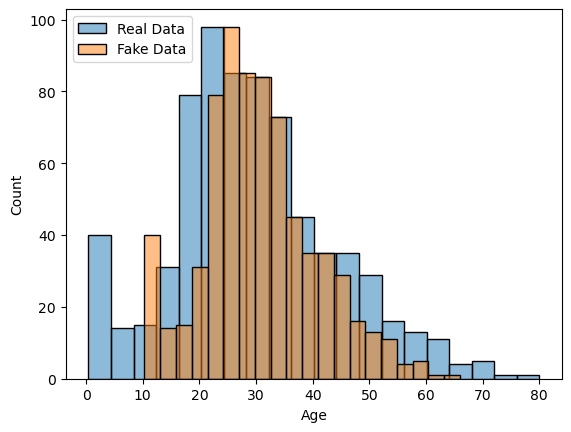

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

feature = "Age"

sns.histplot(data[feature], label='Real Data', alpha=0.5, ax=ax1)
sns.histplot(0.7*data[feature] + 10, label='Fake Data', alpha=0.5, ax=ax1)
plt.legend(loc='upper left')
plt.show()

In [ ]:
numerical_feature_means["Fare"]

In [ ]:
# Normalize the data
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [ ]:
for ft in NUM_COLUMNS:
    real_df[ft] = (real_df[ft] * numerical_feature_stddev[ft]) + numerical_feature_means[ft]
    fake_df[ft] = (fake_df[ft] * numerical_feature_stddev[ft]) + numerical_feature_means[ft]

In [ ]:
data.head()

In [ ]:
real_df.head()

In [ ]:
real_df.describe()

In [ ]:
fake_df.describe()